In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

from datetime import datetime
from datetime import timedelta
from time import time
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

import warnings

warnings.filterwarnings('ignore')
RANDOM_SEED = np.random.seed(0)

In [2]:
# Exploratory Data Analysis

def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

# Select the database
filename = 'solarPower_50m.csv'

# Read data
df = pd.read_csv(filename, parse_dates=[0], index_col=0, date_parser=parser)

In [3]:
# Extract Basic Info
print(df.head())
print(df.info())

            precip  cloud cover  solar radiation  humidity  pressure  \
2019-12-01   0.000         72.0             27.9      87.3    1024.4   
2019-12-02   0.120         41.2              NaN      82.0    1032.6   
2019-12-03   0.000         59.8             42.5      82.6    1027.7   
2019-12-04   0.096         26.2             43.8      90.6    1020.7   
2019-12-05   0.134         85.2             26.5      91.5    1019.4   

            UV index  temp min  temp max  solar energy  PV output  
2019-12-01       2.0       0.9       5.4           2.4      0.748  
2019-12-02       2.0      -1.1       5.8           3.9      1.122  
2019-12-03       3.0       2.1       8.2           3.7      1.091  
2019-12-04       3.0       1.0       6.9           3.7      1.060  
2019-12-05       2.0       1.9       9.7           2.3      0.712  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 793 entries, 2019-12-01 to 2022-01-31
Data columns (total 10 columns):
 #   Column           Non-Null Coun

In [4]:
# Identify Missing Values
df.isnull().sum()

precip              0
cloud cover         0
solar radiation    33
humidity            0
pressure            1
UV index            0
temp min            0
temp max            0
solar energy        0
PV output           0
dtype: int64

In [5]:
# Introduce other useful features
df['PV output lag1'] = df['PV output'].shift(1)  # Yesterday's PV output
df["average_temp"] = (df["temp max"] + df["temp min"]) / 2

In [6]:
# Impute missing values with average of nearest neighbours (kNN)
from sklearn.impute import KNNImputer

impute = KNNImputer(n_neighbors=5)

for i in ['solar radiation', 'pressure', 'PV output lag1']:
    df[i] = impute.fit_transform(df[[i]])

df.isnull().sum()

precip             0
cloud cover        0
solar radiation    0
humidity           0
pressure           0
UV index           0
temp min           0
temp max           0
solar energy       0
PV output          0
PV output lag1     0
average_temp       0
dtype: int64

In [15]:
# Identify Duplicates
df.duplicated().sum()

0

In [18]:
# Analyse the modified data
print(df.describe())

           precip  cloud cover  solar radiation    humidity     pressure  \
count  793.000000   793.000000       793.000000  793.000000   793.000000   
mean     2.652846    66.108701       108.408684   83.719420  1015.693939   
std      4.604500    20.495106        82.758567    9.526572    11.448824   
min      0.000000     0.000000         7.200000   47.700000   975.100000   
25%      0.024000    53.400000        33.300000   78.500000  1008.300000   
50%      0.506000    68.200000        96.000000   85.400000  1016.700000   
75%      3.340000    82.200000       161.600000   91.000000  1023.700000   
max     36.276000   100.000000       319.700000   98.900000  1048.400000   

         UV index    temp min    temp max  solar energy   PV output  \
count  793.000000  793.000000  793.000000    793.000000  793.000000   
mean     4.050441    7.019546   13.164817      9.262169    2.804861   
std      2.471040    4.598832    5.340954      7.247400    2.044960   
min      0.000000   -3.900000  

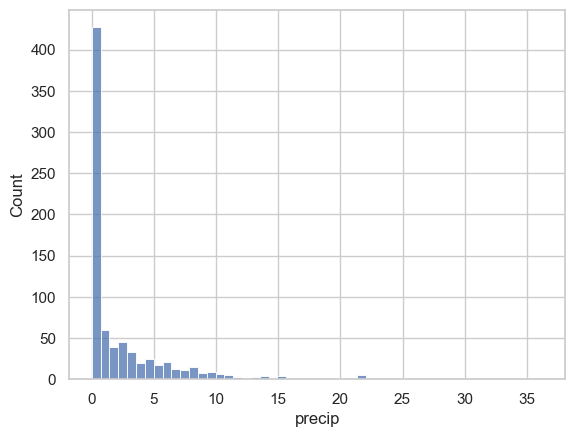

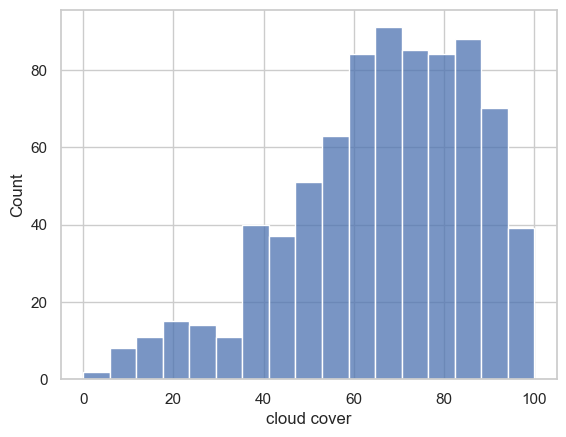

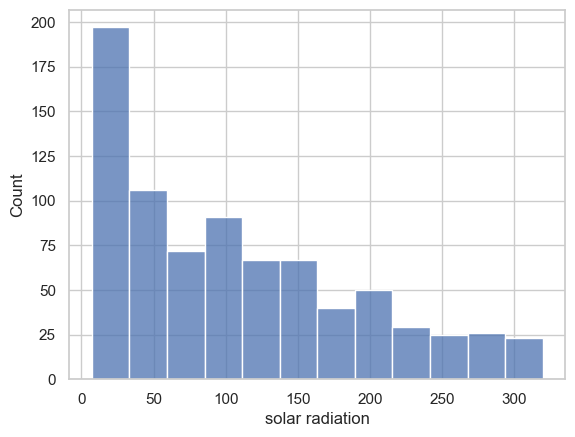

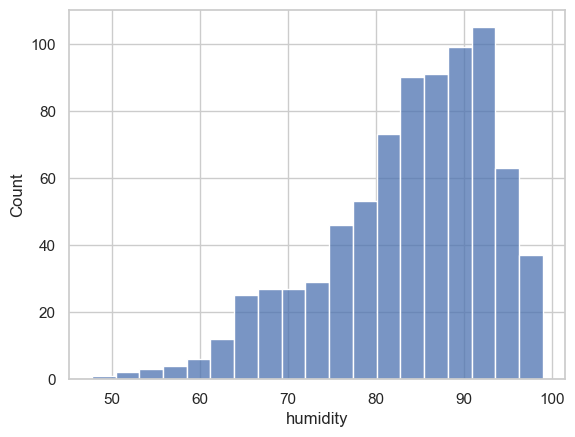

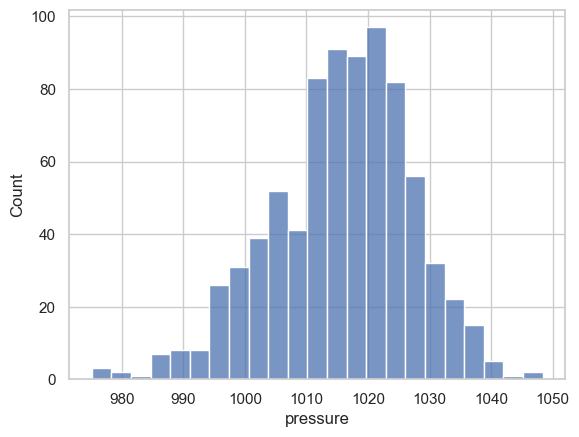

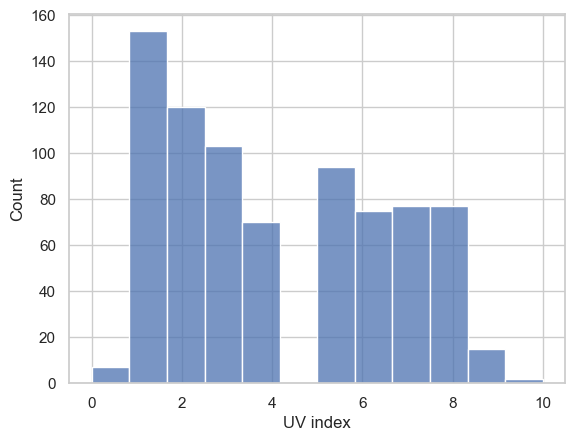

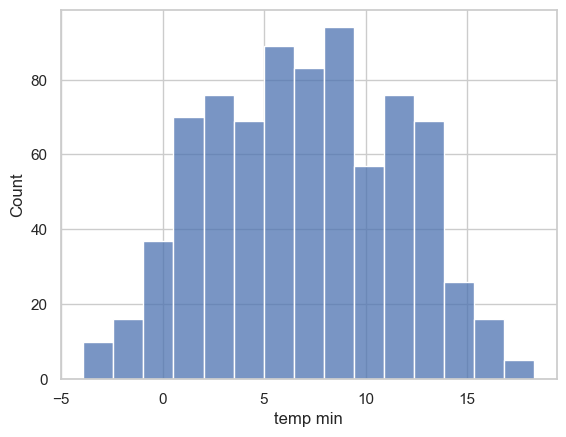

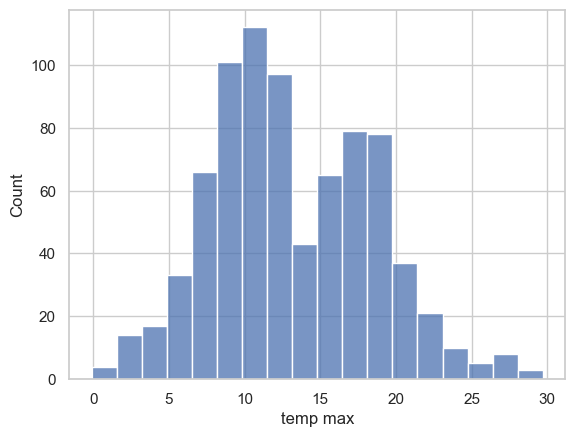

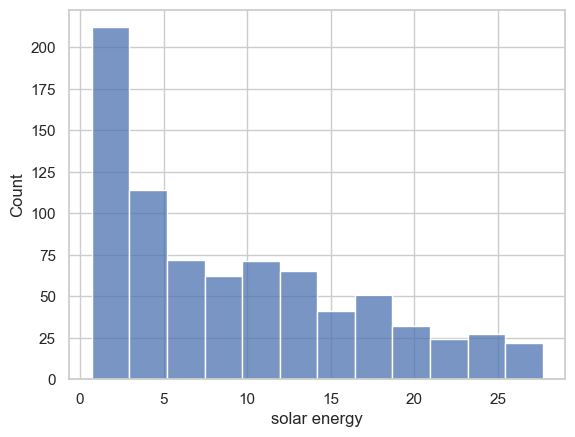

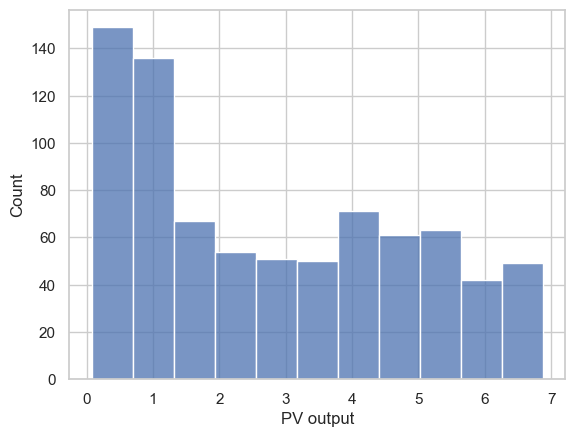

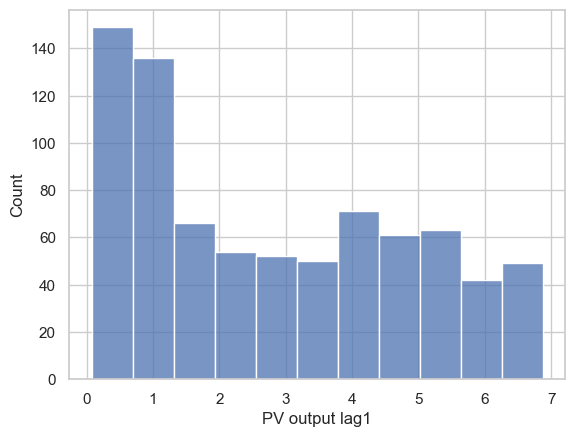

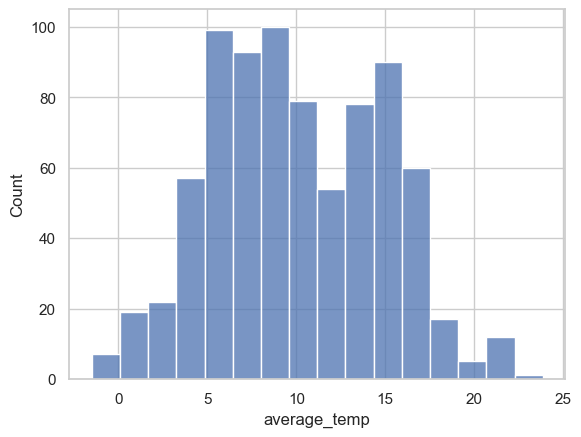

In [21]:
# Understanding the Distribution with Histogram
for i in df.select_dtypes(include='number').columns:
    sns.histplot(data=df, x=i)
    plt.show()

In [24]:
# Logarithmic transformation for skewed distribution
df['log_precip'] = np.log(df['precip'] + 1)
df['log_s_radiation'] = np.log(df['solar radiation'] + 1)
df['log_s_energy'] = np.log(df['solar energy'] + 1)
df['log_humidity'] = np.log(df['humidity'] + 1)
df['log_cc'] = np.log(df['cloud cover'] + 1)

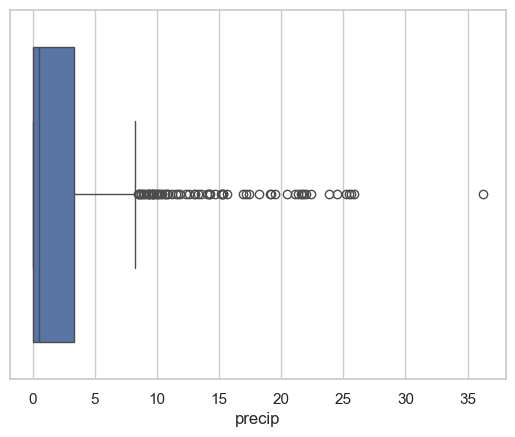

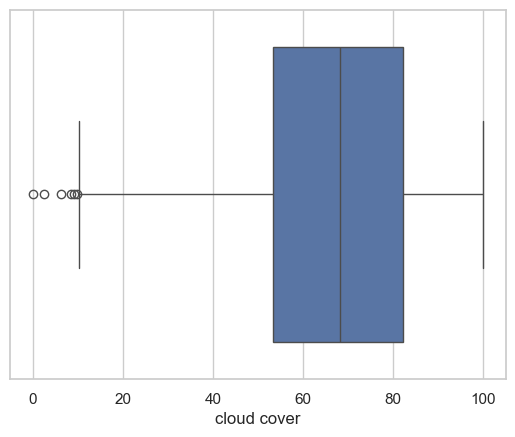

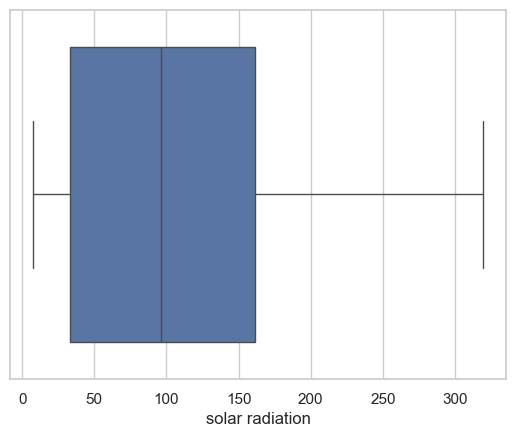

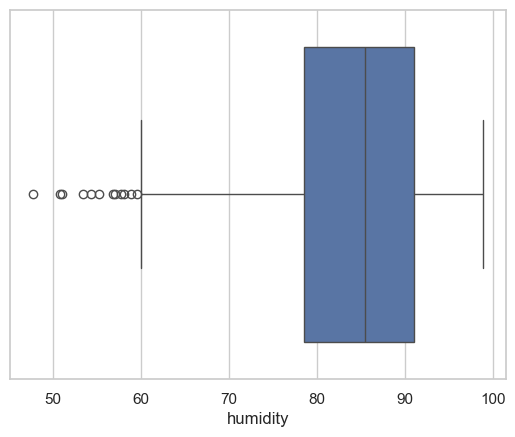

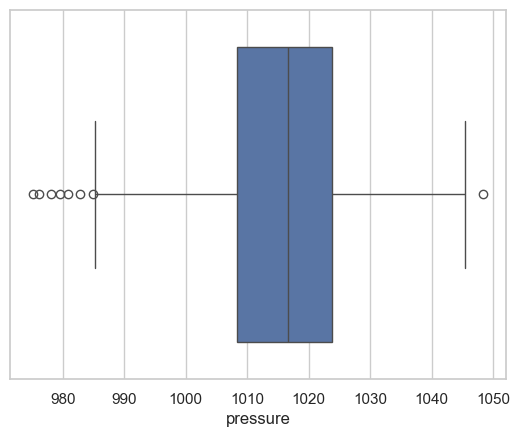

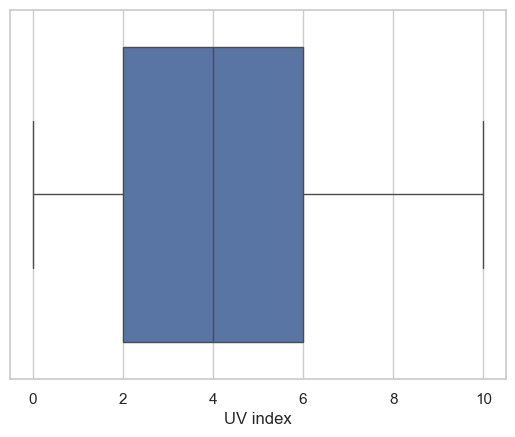

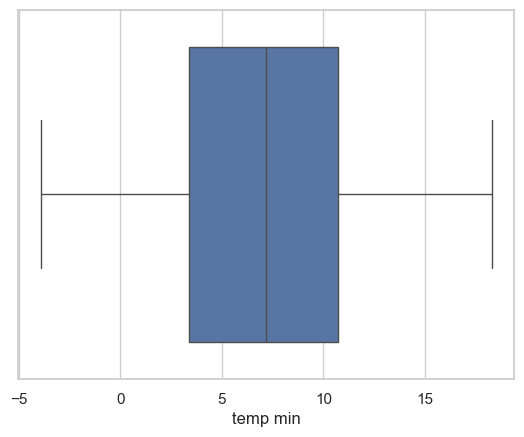

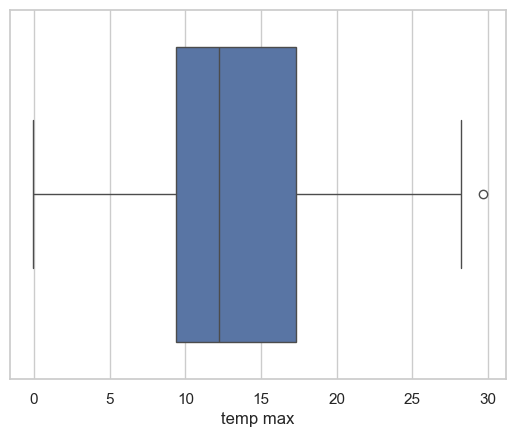

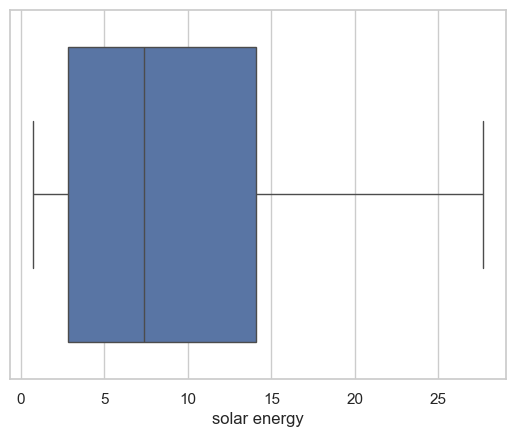

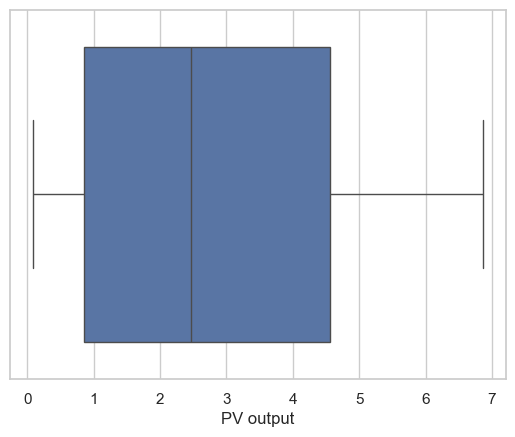

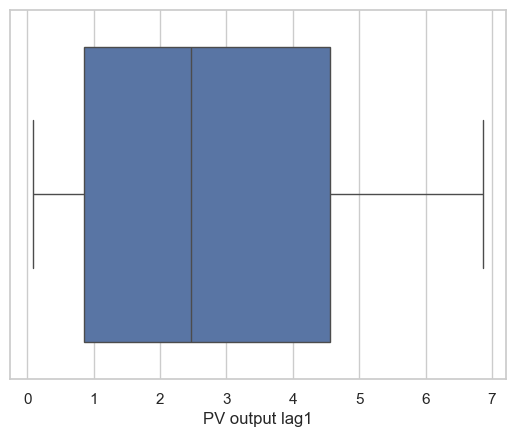

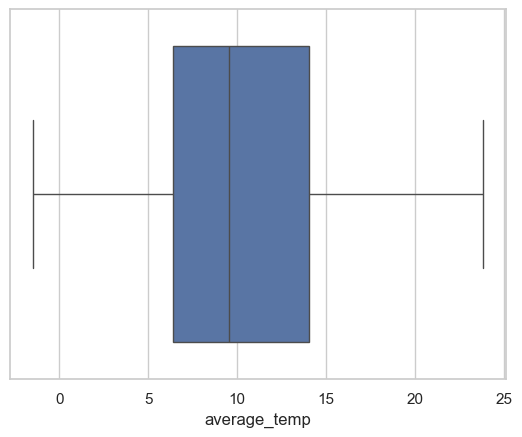

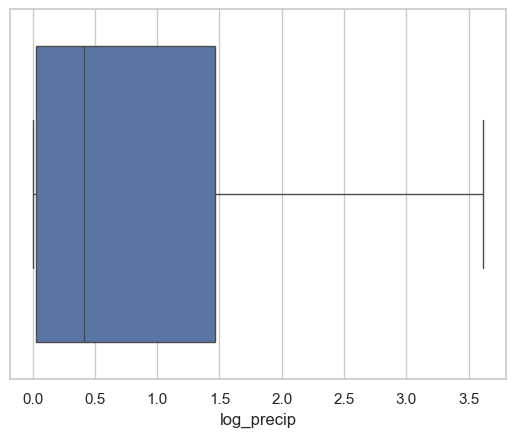

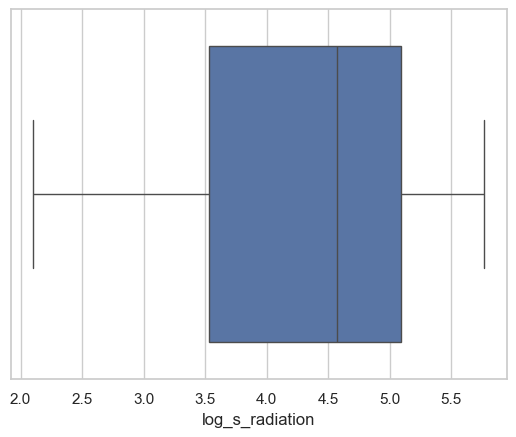

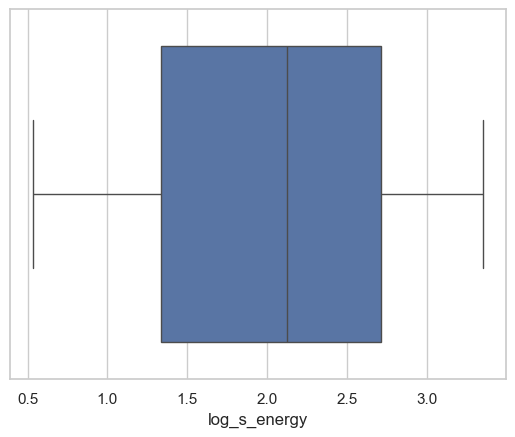

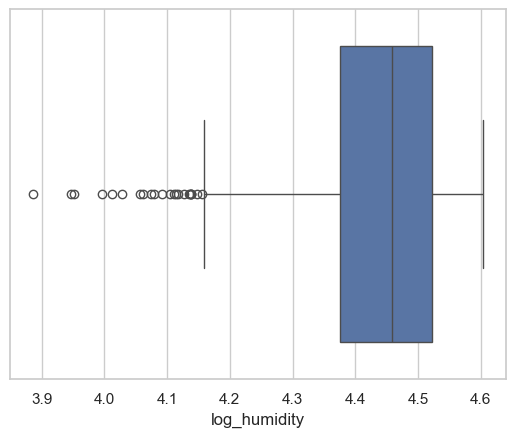

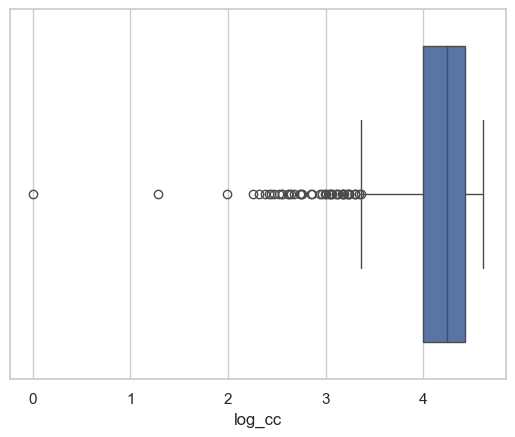

In [27]:
# Identify Outliers
for i in df.select_dtypes(include='number').columns:
    sns.boxplot(data=df, x=i)
    plt.show()

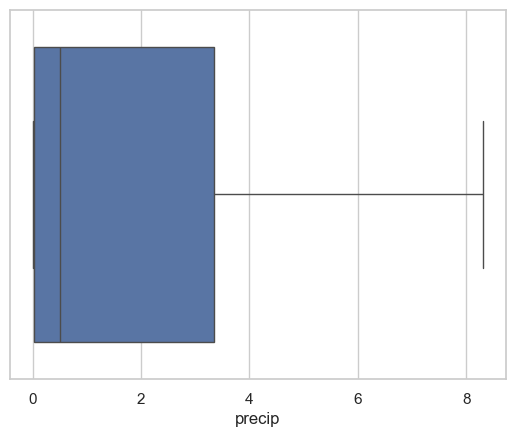

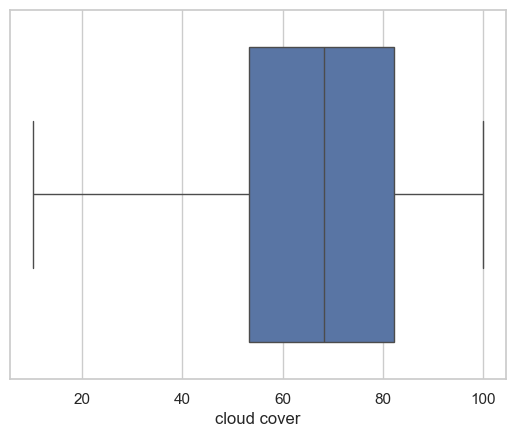

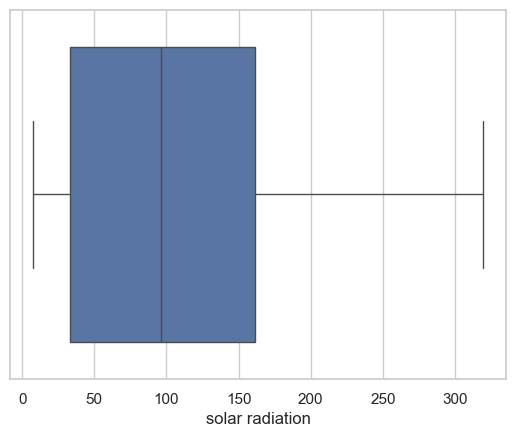

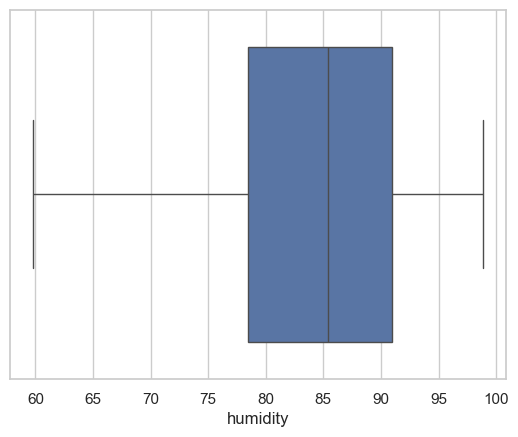

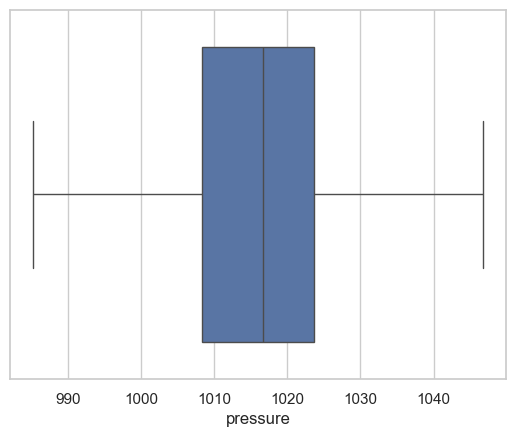

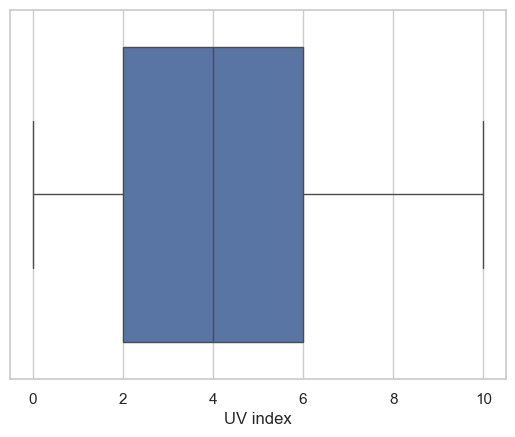

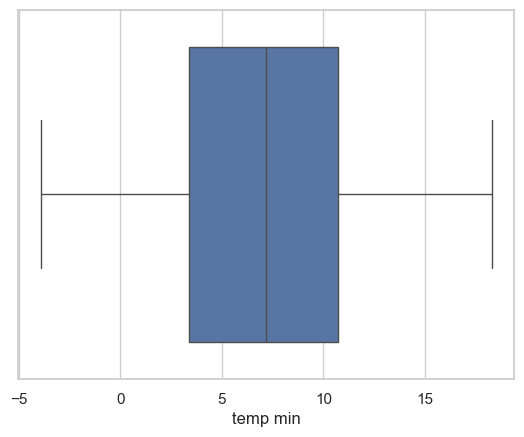

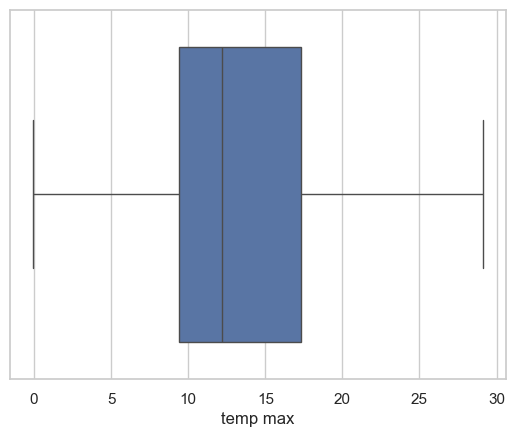

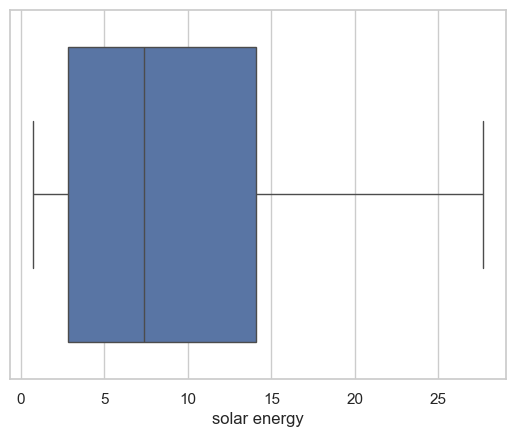

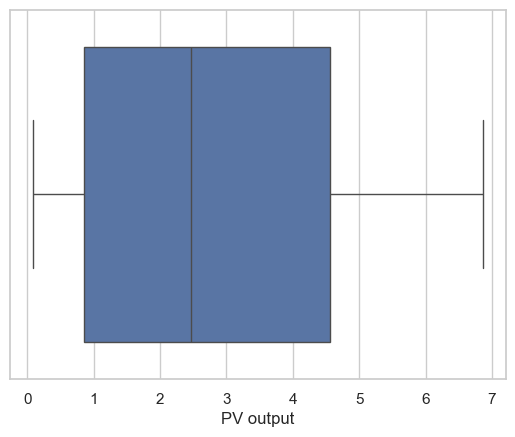

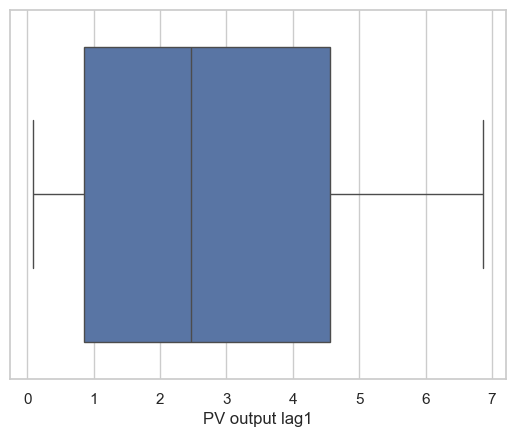

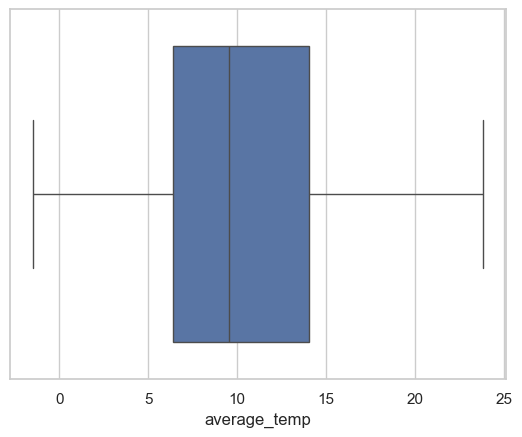

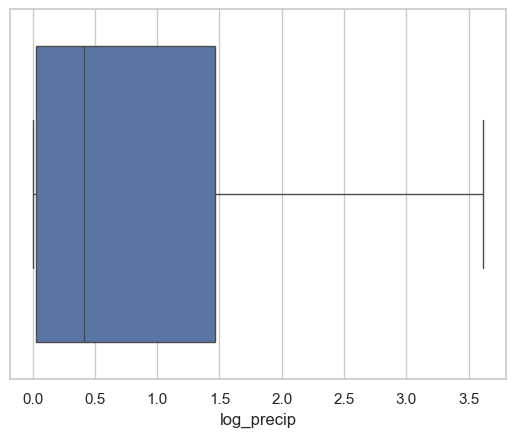

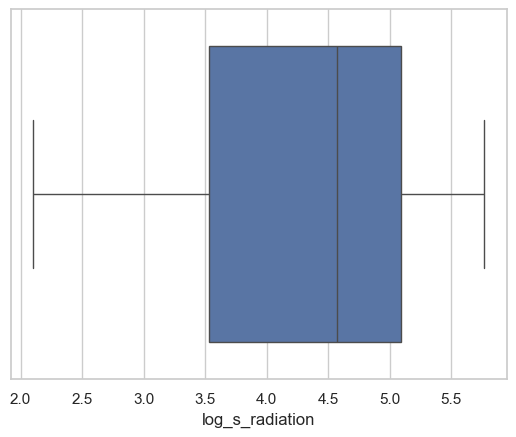

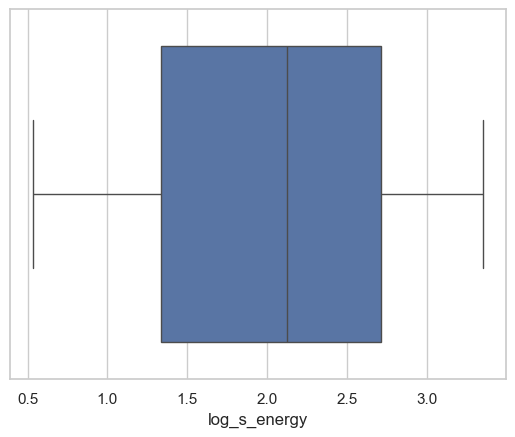

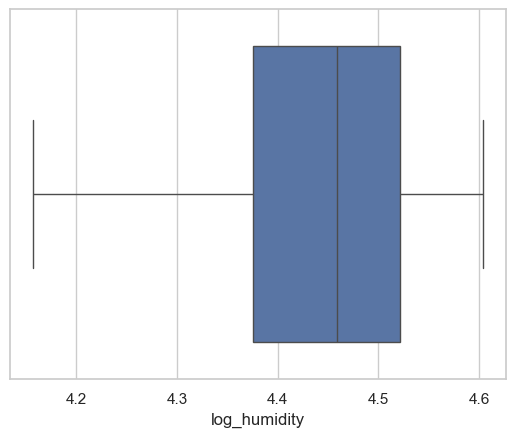

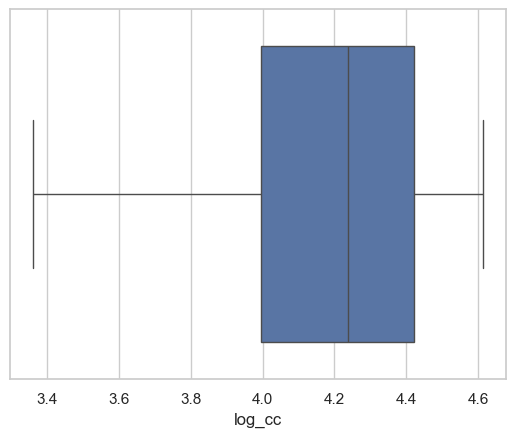

In [30]:
# Define a function to get the limit for outliers of a column
def limit(col):
    q1,q3 = np.percentile(col,[25,75])
    iqr = q3-q1
    ll= q1-1.5*iqr
    ul= q3+1.5*iqr
    return ll,ul

# Treating the required columns 
for i in ['precip', 'cloud cover', 'pressure', 'humidity', 'temp max', 'log_humidity', 'log_cc']:
    ll,ul = limit(df[i])
    df[i]=np.where(df[i]<ll,ll,df[i])
    df[i]=np.where(df[i]>ul,ul,df[i])
    
for i in df.select_dtypes(include='number').columns:
    sns.boxplot(data=df, x=i)
    plt.show()

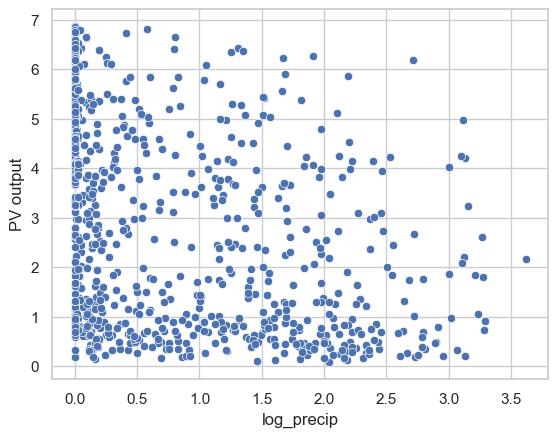

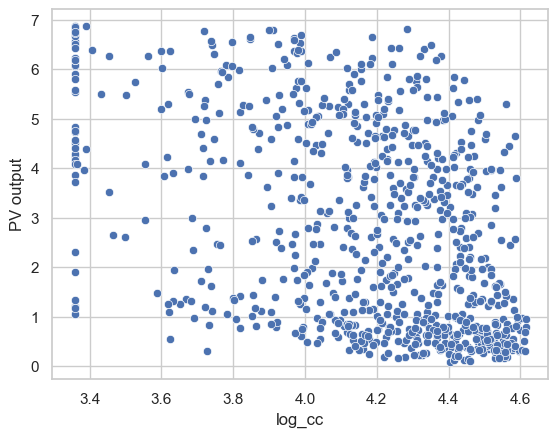

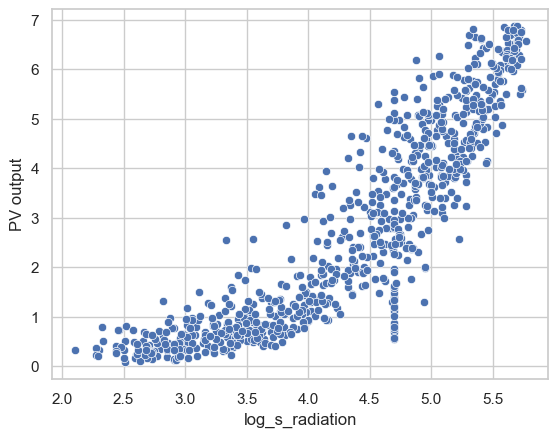

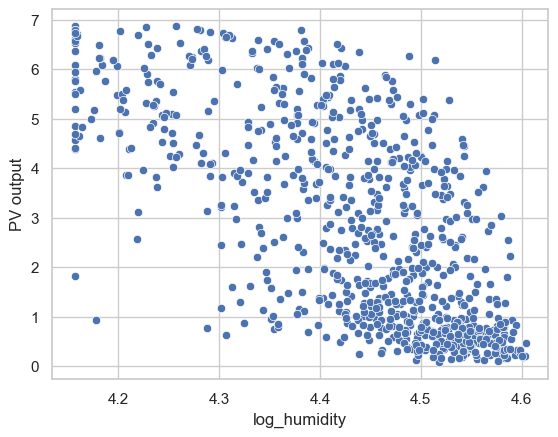

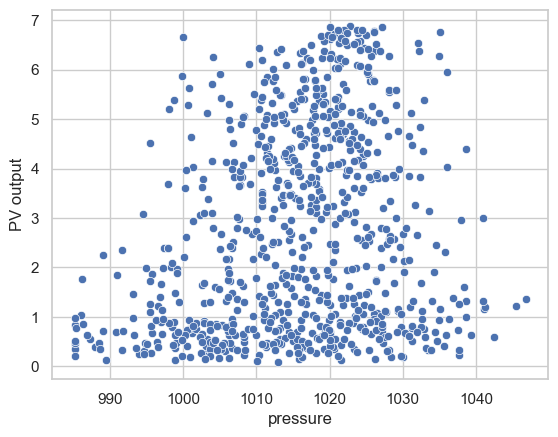

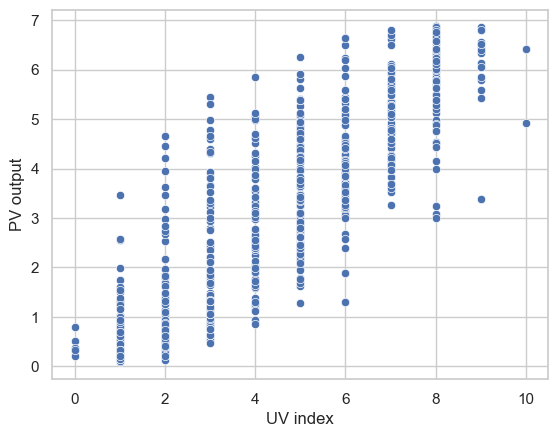

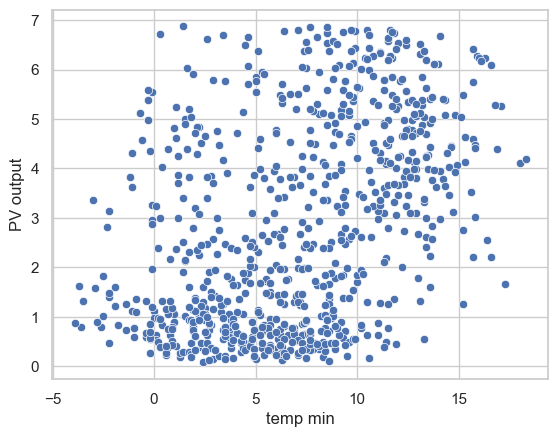

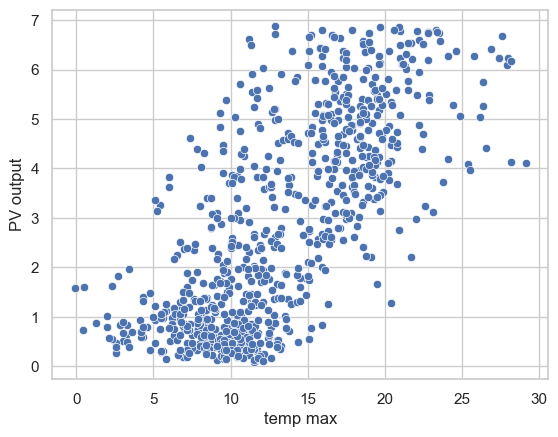

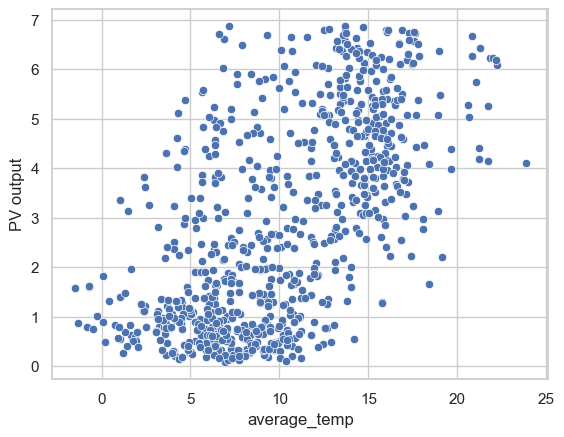

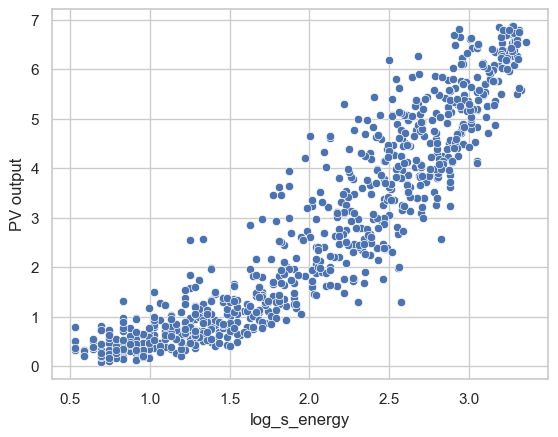

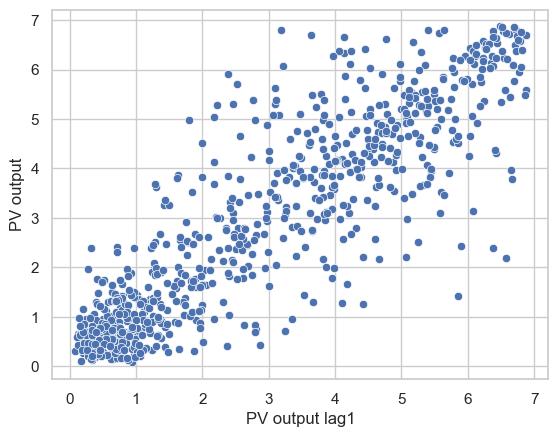

In [33]:
# Understanding Corelation
features = ['log_precip', 'log_cc', 'log_s_radiation', 'log_humidity', 'pressure',
       'UV index', 'temp min', 'temp max', 'average_temp', 'log_s_energy', 'PV output lag1']
# Correlations on scatter plot
for i in features:
    sns.scatterplot(data=df, x=i, y='PV output')
    plt.show()

<Figure size 1000x600 with 0 Axes>

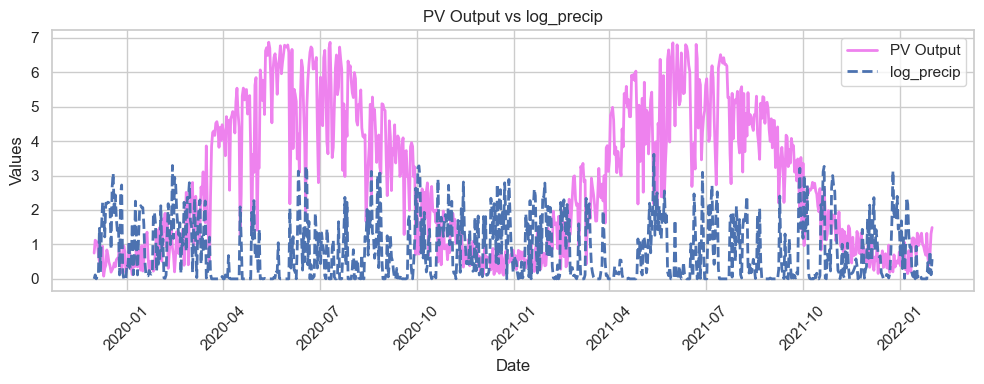

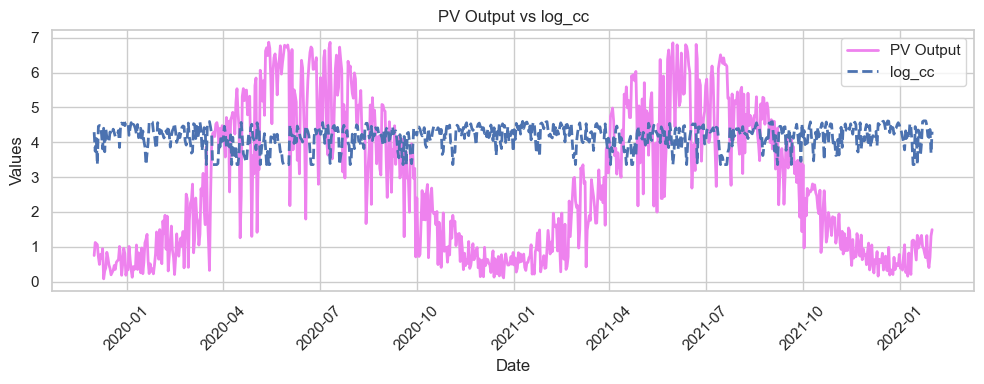

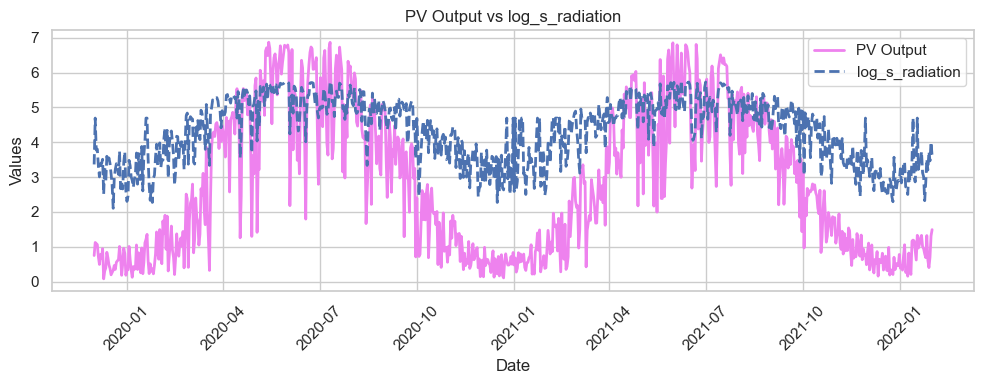

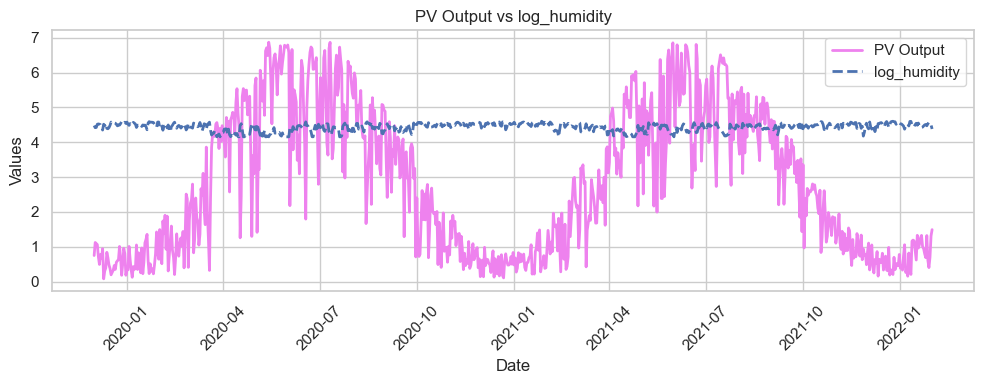

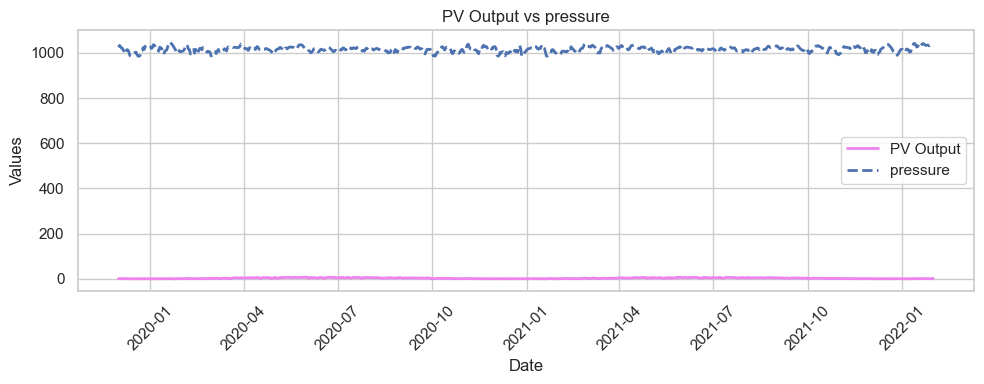

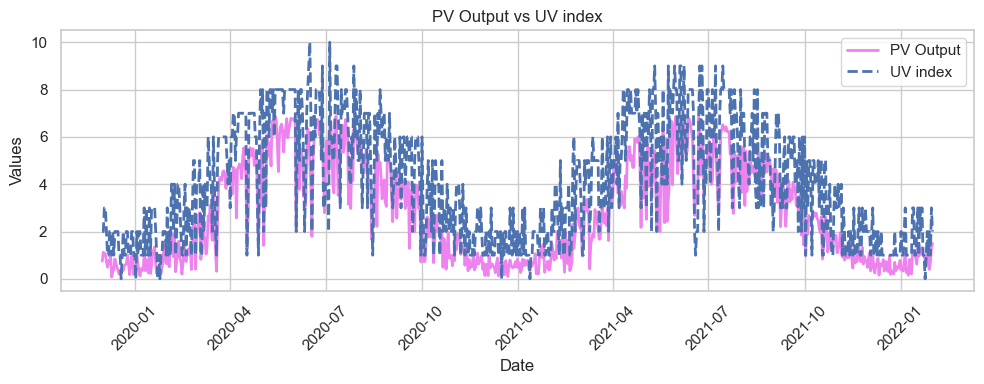

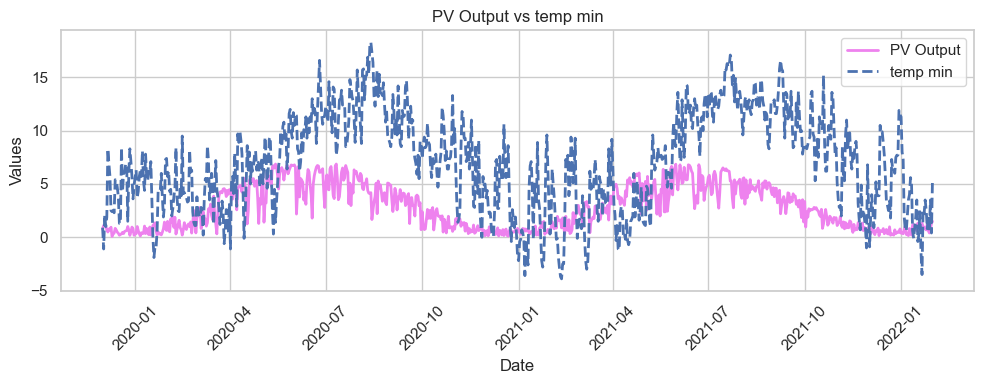

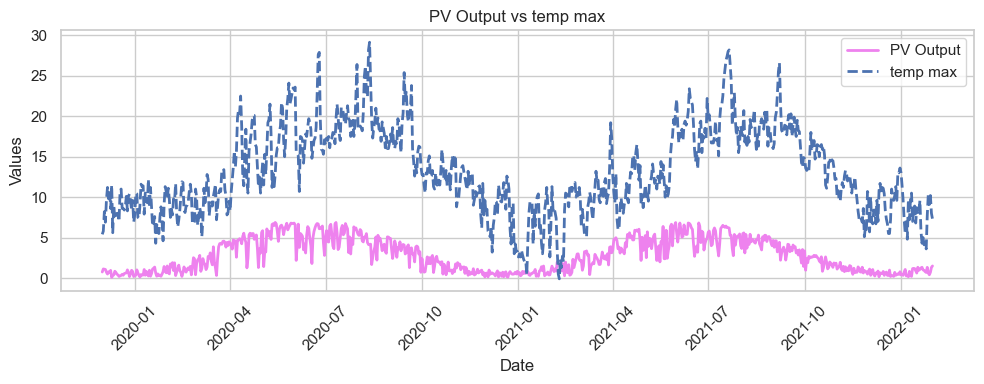

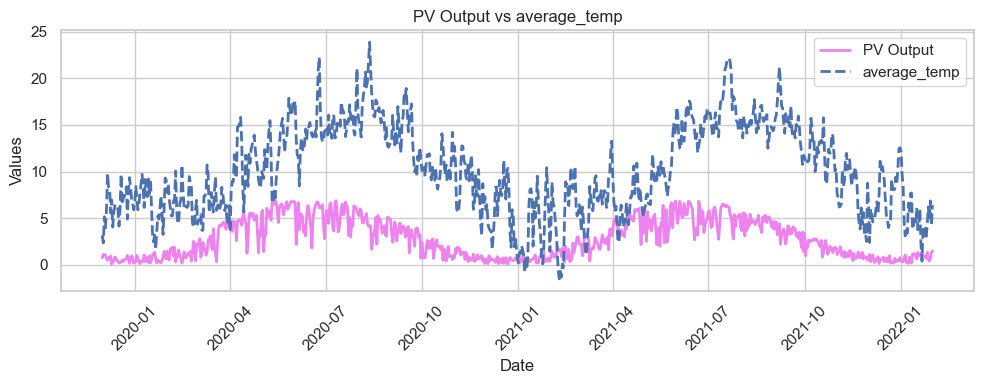

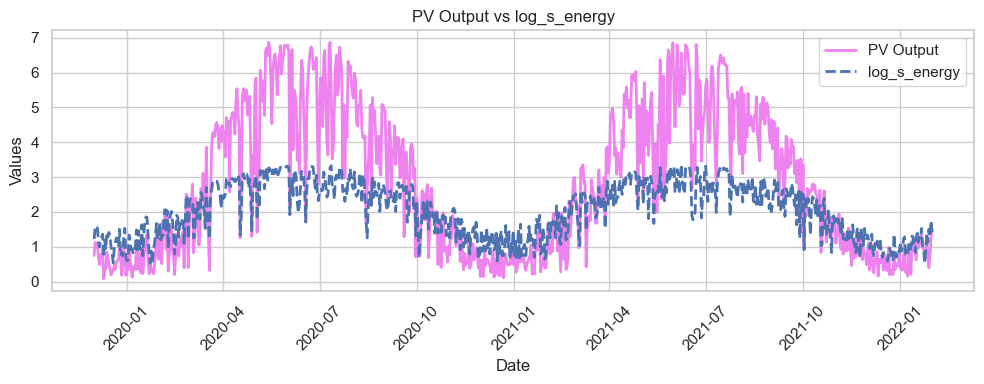

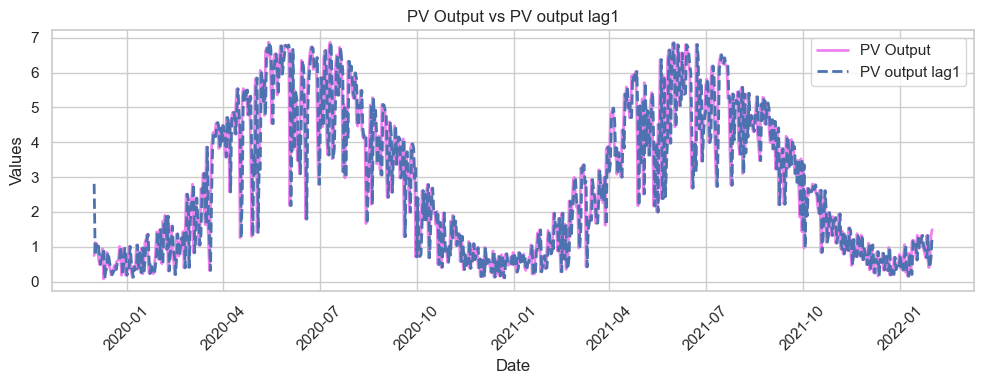

In [36]:
# Compare feature dependence patterns on time-series plots
plt.figure(figsize=(10, 6))

for feature in features:
    plt.figure(figsize=(10, 4))  # Create a new figure for each feature

    plt.plot(df.index, df["PV output"], label="PV Output", color="violet", linewidth=2)
    plt.plot(df.index, df[feature], label=feature, linestyle="dashed", linewidth=2)

    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.title(f"PV Output vs {feature}")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [39]:
# Select Features to balance the predictions
X = df.drop(columns=['precip', 'humidity', 'cloud cover', 'solar radiation', 'solar energy', 'pressure', 'temp min', 'temp max', 'PV output'])

print(X.describe())

         UV index  PV output lag1  average_temp  log_precip  log_s_radiation  \
count  793.000000      793.000000    793.000000  793.000000       793.000000   
mean     4.050441        2.806520     10.092182    0.809816         4.333872   
std      2.471040        2.044426      4.764101    0.899425         0.926690   
min      0.000000        0.078000     -1.500000    0.000000         2.104134   
25%      2.000000        0.855000      6.400000    0.023717         3.535145   
50%      4.000000        2.468000      9.550000    0.409457         4.574711   
75%      6.000000        4.566000     14.050000    1.467874         5.091293   
max     10.000000        6.873000     23.850000    3.618350         5.770506   

       log_s_energy  log_humidity      log_cc  
count    793.000000    793.000000  793.000000  
mean       2.045045      4.434803    4.167204  
std        0.789482      0.113080    0.327409  
min        0.530628      4.156710    3.359039  
25%        1.335001      4.375757    3.

In [42]:
# Assign target variable
y = df['PV output']

print(y.describe())

count    793.000000
mean       2.804861
std        2.044960
min        0.078000
25%        0.855000
50%        2.462000
75%        4.566000
max        6.873000
Name: PV output, dtype: float64


In [45]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Train-test split (first 2 years for training, last 2 months for testing)
train_size = 731  
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Scaling features for standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Selecting the parameters
param_grid = {
    "n_estimators": [60, 80, 100],
    "max_depth": [10, 20, 25],
    "min_samples_split": [1, 2, 5],
    "min_samples_leaf": [2, 4, 8]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
rf_best = grid_search.best_estimator_

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 80}


In [48]:
# Training Random Forest model
rf_model = RandomForestRegressor(max_depth=20, min_samples_leaf = 4, min_samples_split = 2, n_estimators=80, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Get Predictions
y_pred_train = rf_model.predict(X_train_scaled)
y_pred_test = rf_model.predict(X_test_scaled)

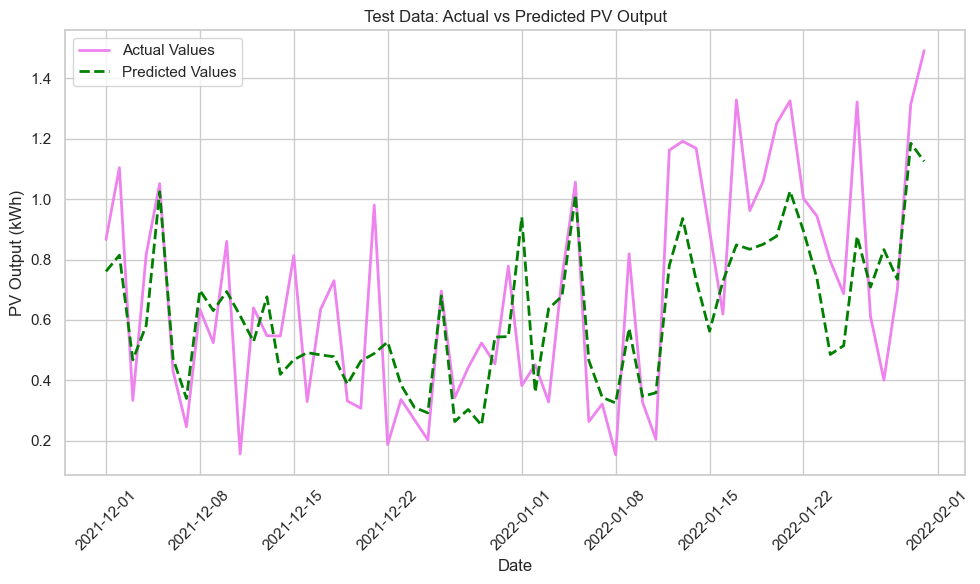

In [51]:
# Plot Actual vs Predicted PV Output on Test Data
plt.figure(figsize=(10, 6))

plt.plot(y_test.index, y_test, label='Actual Values', color='violet', linewidth=2)

plt.plot(y_test.index, y_pred_test, label='Predicted Values', color='green', linestyle='dashed', linewidth=2)
plt.xlabel('Date')
plt.ylabel('PV Output (kWh)')
plt.title('Test Data: Actual vs Predicted PV Output')
plt.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluation

# Function to evaluate model performance
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    print(f"Random Forest Performance on {dataset_name}:")
    print(f"  - Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  - Mean Squared Error (MSE): {mse:.4f}")

# Evaluate Training Data Performance (Check Overfitting)
evaluate_model(y_train, y_pred_train, "Training Data")

# Evaluate Test Data Performance
evaluate_model(y_test, y_pred_test, "Test Data")

Random Forest Performance on Training Data:
  - Mean Absolute Error (MAE): 0.2717
  - Mean Squared Error (MSE): 0.1425
Random Forest Performance on Test Data:
  - Mean Absolute Error (MAE): 0.1970
  - Mean Squared Error (MSE): 0.0581


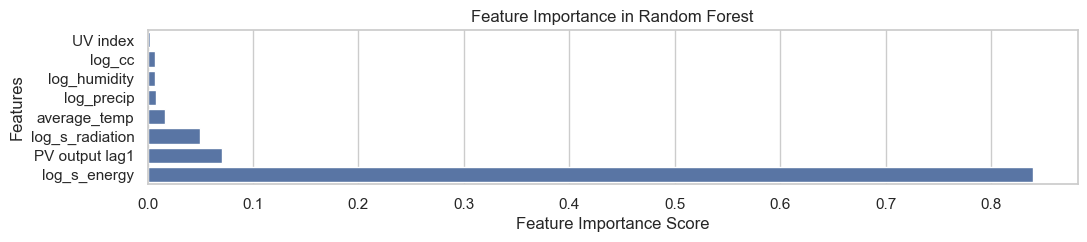

UV index           0.002380
log_cc             0.006968
log_humidity       0.006987
log_precip         0.008231
average_temp       0.016287
log_s_radiation    0.049320
PV output lag1     0.070283
log_s_energy       0.839545
dtype: float64


In [57]:
feature_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=True)

plt.figure(figsize=(12,2))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.show()
print(feature_importance)